# Week 04a Assignment weather data

Welcome to week four of this course programming 1. Analyzing time related data such as estimating seasonal effect, or year effect might be a challenge. How to filter the essential information from the noise? How to apply signal analysis with noisy data. How to make compact useful visualizations? Python has several constructs to handle date time related data. The relevant classes for making plots are Locators and Formatters. Locators determine where the ticks are, and formatters control the formatting of tick labels. The relevant class for date time data is the pandas datetime data type, which has methods like resample and several possibilities to display data (frequencies). As a study case we will work with weather data. If you have data that fits the learning goals, you can bring your own data.

Keywords: signal processing, smoothing, resample, formatters and locators, datetime object

More to read: 

- https://fennaf.gitbook.io/bfvm22prog1/
- https://machinelearningmastery.com/time-series-data-visualization-with-python/
- https://towardsdatascience.com/how-to-plot-time-series-86b5358197d6
- In the https://pandas.pydata.org/docs/reference/offset_frequency.html you can find more about frequencies and in the documentation
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html you can read all the methods of this datetime object.
- https://en.wikipedia.org/wiki/Smoothing


Learning objectives

- load, inspect and clean a dataset
- reshape dataframes to group data in a certain frequency
- apply smoothing technologies
- Create useful visualisation with timeseries data
- Maintain development environment 
- Apply coding standards and FAIR principles

Please add topics you want to learn here: https://padlet.com/ffeenstra1/z9duo25d39dcgezz


## Assignment

You will to organise your data into the required format and apply smoothing. In this assignment we will work with weatherdata from the KNMI. A subset of weatherdata is for you available in the file: `KNMI_20181231`. The data consist of several stations with daily weather data of several years. Your task is to make a plot similar to the plot below. 

<img src="../images/weather.png" alt="drawing" width="400"/>


Furthermore the plot needs the following enhancements

1. proper titles and ticks
2. widgets selecting a particular year or all years
3. lines need to be smoothed
3. legends needs to be added

Use your creativity. Consider colors, alpha settings, sizes etc. 

Learning outcomes

- load, inspect and clean a dataset 
- reformat dataframes
- apply smoothing technologies
- visualize timeseries data

The assignment consists of 6 parts:

- [part 1: load the data](#0)
- [part 2: clean the data](#1)
- [part 3: reformat data](#2)
- [part 4: smooth the data](#3)
- [part 5: visualize the data](#4)
- [part 6: Challenge](#5)

Part 1 and 5 are mandatory, part 6 is optional (bonus)
Mind you that you cannot copy code without referencing the code. If you copy code you need to be able to explain your code verbally and you will not get the full score. 


NB if you want to make a plot with more actual data you can download data from https://openweathermap.org/api 


---

<a name='0'></a>
## Part 1: Load the data

Either load the dataset `KNMI_20181231.csv` or `KNMI_20181231.txt.tsv`. 
Preferably we read the data not with a hard coded data path but using a config file. See https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml. The dataheaders contain spaces and are not very self explainable. Change this into more readable ones. Select data from a station. Station 270 is in the neighborhood of Groningen. For our plot we only need the the mean, minimum and maximum temperature. Of course you are welcome to select other data if you think it might be useful for your visualization. The data should look something like this:


In [23]:
import pandas as pd
import numpy as np

import yaml

with open("config.yml", "r") as f:
    config = yaml.safe_load(f)
df = pd.read_csv(config["knmi"],sep="\t",skiprows=64)

df[['station','Date','Tmean','Tmin','Tmax','SQ','DR','RH']] = df["#"].str.split(",", expand=True)
df = df[['station','Date','Tmean','Tmin','Tmax']]
df['station'] = df['station'].astype(np.int64)
df['Tmean'] = pd.to_numeric(df["Tmean"],errors = 'coerce')
df['Tmin'] = pd.to_numeric(df["Tmin"],errors = 'coerce')
df['Tmax'] = pd.to_numeric(df["Tmax"],errors = 'coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['station']==270]
df.head()

,station,Date,Tmean,Tmin,Tmax
97641,270,2000-01-01,42.0,-4.0,79.0
97642,270,2000-01-02,55.0,33.0,74.0
97643,270,2000-01-03,74.0,49.0,89.0
97644,270,2000-01-04,46.0,22.0,75.0
97645,270,2000-01-05,41.0,14.0,56.0


---

<a name='1'></a>
## Part 2: Clean the data

The data ia not clean. There are empty cells in the dataframe which needs to be replaced with NaN's and the temperature is in centidegrees which needs to be transformed into degrees. The date field needs a datetime format. For visualization convience we would like to remove the leap year. Conduct the cleaning.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')</li>
    <li>regex for empty cells = `^\s*$` </li>
    <li>remove month == 2 & day == 29</li> 
</ul>
</details>

In [24]:
#Test your outcome
#write code to check if you have done the above
df = df.replace(r'^\s*$', np.nan, regex=True)
df[['Tmean','Tmin','Tmax']]=df[['Tmean','Tmin','Tmax']]/10
df = df[~((df['Date'].dt.month == 2) & (df['Date'].dt.day== 29))]
print(df.info())
df.set_index('Date',inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6935 entries, 97641 to 104580
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   station  6935 non-null   int64         
 1   Date     6935 non-null   datetime64[ns]
 2   Tmean    6935 non-null   float64       
 3   Tmin     6935 non-null   float64       
 4   Tmax     6935 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 325.1 KB
None


### Expected outcome

---

<a name='2'></a>
## Part 3: Reform your data

First we will split the data in data from 2018 and data before 2018. Best is to split this in two dataframes. 
Next we need for the non 2018 data the minimum values for each day and the maximum values for each day. So we look for the minimum value out of all january-01 minimum values (regardless the year). Create a dataframe with 365 days containing the ultimate minimum and the ultimate maximum per day. 


In [26]:
df_before2018 = df[df.index.year <2018]
df_after2018 = df[df.index.year==2018]

def month_day(df_multipleyears):
    #your code to reform data here
    df_multipleyears = df_multipleyears[['Tmin','Tmax']]
    df_groupedbymonthday = df_multipleyears.groupby([
        df_multipleyears.index.month.rename('month'),
        df_multipleyears.index.day.rename('day')]).min('{:,.2f}'.format)
    print(df_groupedbymonthday)

In [27]:
#Test your code
def test_reformed(df):
    df = df[(df.index.year > 2007) & (df.index.year < 2018)]
    month_day(df)
test_reformed(df_before2018)

           Tmin  Tmax
month day            
1     1    -5.8   1.0
      2    -7.5  -1.4
      3   -12.6   0.1
      4    -4.1   0.8
      5    -6.0  -1.2
...         ...   ...
12    27   -4.8   1.3
      28   -4.2   0.3
      29   -6.7  -2.6
      30  -10.2  -2.4
      31  -10.6   0.0

[365 rows x 2 columns]


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>use the dt.month and dt.day to groupby</li>
</ul>
</details>

### Expected outcome
Note, the layout or names my differ, but the length should be 365 and the minimum values should be the same

---

<a name='3'></a>
## Part 4: Smooth the data

Make a function that takes an array or a dataframe column and returns an array of smoothed data. Explain in words why you choose a certain smoothing algoritm. Ask the signal analysis teacher if you want some advice.


/var/folders/2g/j1xm7z8s2x3g6pdyfyyp1_d00000gn/T/ipykernel_3744/1680407624.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smooth']=df[col].ewm(span = 200).mean()


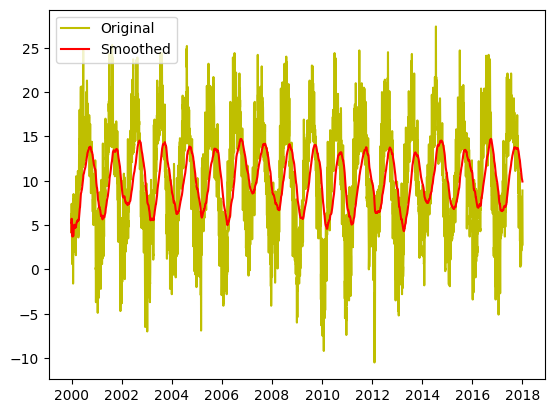

In [19]:
#your code here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def smooth_data(df,col):
    df['smooth']=df[col].ewm(span = 200).mean()
    return df

df_smooth = smooth_data(df_before2018,'Tmean')

plt.plot(df_before2018.index, df_before2018['Tmean'], label='Original',color='y')
plt.plot(df_before2018.index, df_smooth['smooth'], label='Smoothed',color='r')
plt.legend(loc='upper left')
plt.show()

#your motivation here
# I used ewm Because:
# The data doesn’t get affected much when outliers occur and 
# EWM is for detecting smaller shifts in the mean of the time-bound process. 
# An exponentially weighted moving average is also highly studied and 
# used as a model to find a moving average of data.
# and also very useful in forecasting the event based on past data.

---

<a name='4'></a>
## Part 5: Visualize the data

Plot the mean temperature of the year 2018. Create a shaded band with the ultimate minimum values and the ultimate maximum values from the multi-year dataset. Add labels, titles and legends. Use proper ranges. Be creative to make the plot attractive. 



<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>use from bokeh.models import Band</li>
    <li>use ColumnDataSource to parse data arrays</li>
    <li>look for xaxis tick formatters</li>
</ul>
</details>

In [28]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import Band, ColumnDataSource
from bokeh.models import DatetimeTickFormatter
import pandas as pd
import numpy as np

output_file("band.html", title="Part5")

x = df_after2018.index
y = df_after2018['Tmean']
df = pd.DataFrame(data=dict(x=x, y=y)).sort_values(by="x")

df['lower'] = df_after2018['Tmin']
df['upper'] = df_after2018['Tmax']
source = ColumnDataSource(df.reset_index())

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
p = figure(tools=TOOLS,x_axis_type='datetime')
p.xaxis.formatter=DatetimeTickFormatter(months=["%d,%m,%Y"])

p.scatter(x='x', y='y', line_color=None, fill_alpha=0.3, size=5, source=source)

station_band = Band(base='x', lower='lower', upper='upper', source=source, level='underlay',
            fill_alpha=1.0, line_width=1, line_color='black')
p.add_layout(station_band)

p.title.text = "Temperature"
p.xgrid[0].grid_line_color=None
p.ygrid[0].grid_line_alpha=0.5
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Mean temperature'

show(p)

---

<a name='5'></a>
## Part 6: Challenge

Make a widget in which you can select the year range for the multiyear set. Or maybe a widget were you choose a different station. Add this to your layout to make the plot interactive. Add another widget to select or deselect the smoother. Inspiration: https://demo.bokeh.org/weather